In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate

from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.optimize import least_squares

from scipy import stats
import numpy as np
import math
from statistics import mean
from scipy.spatial import distance
from networkx import nx

from numpy.random import default_rng

In [3]:
rng = default_rng()


realize_degree = 50  ##### Number of replicates
area_range = 15      ##### Number of area values that correspond to different assembled communities  


are_pow_all = []     
n_species_all = []   ##### array to store number of surviving species for each area value and replicate

N_sp = 100           ##### Number of species in the species pool

mig = 0.01   ##### The constant \lambda in the immigration term

## The function below represents the GLV equations with an immigration term in matrix form 

In [4]:
def f(t,y):

    return np.multiply(y,r  + np.dot( ( 1/(are**1)  )*A ,y**1 ) - np.dot( ( r/(K*(are/are0)**0.25 ) )*np.eye(N_sp), y**1 ) ) + mig*np.exp( - 1000/are**0.5) #####Using usual pre-defined carrying capacities


In [5]:
for ii in range(realize_degree):

    K = np.random.normal(500,30,N_sp)   ##### Carrying capacities

    r = np.random.normal(1, 0.2, N_sp)  ##### Growth rates

    final_pop = []
    final_pop2 = []

    G = nx.erdos_renyi_graph(N_sp, 1, seed=None, directed=False)  ##### Fix interaction links between pairs of species from a random graph with a given connectance

    y0 = np.random.normal(10,0.1,N_sp)  ##### Set initial abundances
    y_init = np.copy(y0)


    A = nx.to_numpy_array(G)            ##### Convert networkX graph to numpy array

    a_rand = np.random.normal(-1, 0.2, np.count_nonzero(A)) ##### Draw interaction strengths from normal distribution

    ##### Uncomment the below lines to draw interactions from an exponential or pareto distribution 
    
    # a_rand = -1*rng.exponential(scale=2,size = np.count_nonzero(A))
    # a_rand = -1*np.random.pareto(2,np.count_nonzero(A))
    
    
    a_rand = iter(a_rand)               ##### Set up array A which is the interaction matrix
    A = np.array([[next(a_rand) if A[i,j]==1 else 0 for j in range(N_sp)] for i in range(N_sp)])
    A = np.array([[A[i,j] if i!=j else 0 for j in range(N_sp) ] for i in range(N_sp)])


    are = 15000                         ##### Initial areas
    are0 = 15000


    for i in range(area_range):

        y0 = np.random.normal(10,0.1,N_sp) ##### Set initial abundances for every area value

        sol = integrate.solve_ivp(f, [0,1000], y0, method = 'RK45', vectorized = False)  


        temp_pop = [sol.y[i, len(sol.t) - 1] for i in range(N_sp) if sol.y[i, len(sol.t) - 1] > 10**-5]
        final_pop.append(temp_pop)

        are = are*0.85                     ##### Update area value after each run


    final_pop = np.array(final_pop)

    are = np.array([ are0*0.85**kk for kk in range(area_range) ]) ##### Array of all area values used
    
    ##### Below, we save results from runs for which at least one species goes extinct

    are_pow = np.array([are[i] for i in range(len(final_pop)) if len(final_pop[i]) < N_sp])

    n_species = np.array([len(final_pop[i+(len(are) - len(are_pow))]) for i in range(len(are_pow))])


    are_pow_all.append(are_pow)
    n_species_all.append(n_species)


## Linear regressions 

In [6]:
are_pow_all = np.array([item for sublist in are_pow_all for item in sublist])  ##### Unpack as a 1-D numpy array
n_species_all = np.array([item for sublist in n_species_all for item in sublist])

m1, c1, rsq1, pv1, ster1 = stats.linregress(np.log(are_pow_all),n_species_all) ##### Semi-log linear regression
print(m1)        ##### Slope
print(c1)        ##### Intercept
print(rsq1**2)   ##### R^2

m2, c2, rsq2, pv2, ster2 = stats.linregress(np.log(are_pow_all),np.log(n_species_all)) ##### Log-log linear regression
print(m2)
print(c2)
print(rsq2**2)



23.419312818723807
-129.33466159093547
0.9459736848018909
0.3512902104845325
1.2301412680881696
0.9390151840152804


## Semi-log linear regression plot

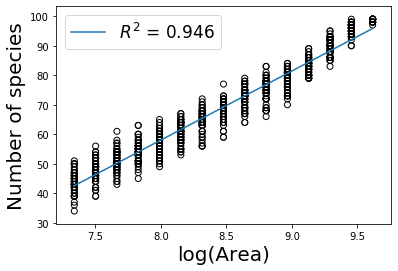

In [7]:
for i in range(len(are_pow_all)):
    plt.scatter(np.log(are_pow_all[i]), n_species_all[i], facecolors='none', edgecolors='k')

plt.plot(np.sort( np.log(are_pow_all) ),m1*np.sort( np.log(are_pow_all) ) + c1, label = "$R^2$ = %.3f" %(rsq1**2)) 
plt.legend(loc="upper left", fontsize=17)
plt.xlabel('log(Area)', fontsize=20)
plt.ylabel('Number of species', fontsize=20)
plt.show()

## Log-log linear regression plot

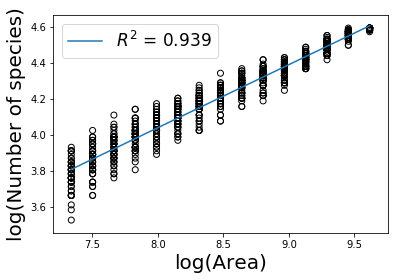

In [8]:
for i in range(len(are_pow_all)):
    plt.scatter(np.log(are_pow_all[i]), np.log(n_species_all[i]), facecolors='none', edgecolors='k')

plt.plot(np.sort( np.log(are_pow_all) ),m2*np.sort( np.log(are_pow_all) ) + c2, label = "$R^2$ = %.3f" %(rsq2**2))  
plt.legend(loc="upper left", fontsize=17)
plt.xlabel('log(Area)', fontsize=20)
plt.ylabel('log(Number of species)', fontsize=20)
plt.show()

## Non-linear least squares analysis

5119.454168856961
4588.513111985567
8.327547121211865e-06
0.002788987645544694
[  23.41931279 -129.33466137]
[0.34567007 3.59620383]


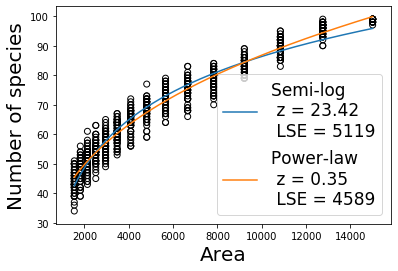

In [9]:
def func1(x, t, y): ##### semi-log function
    return  x[1] + x[0]*np.log(t) - y  

def func2(x, t, y): ##### power-law function
    return  x[1]*(t**x[0]) - y  

def generate_data1(t,a1,a2):
    return  a2 + a1*np.log(t)

def generate_data2(t,a1,a2):
    return  a2*(t**a1)

x0_log = [1,1]      ##### Initial estimates
x0_pow = [1,1]     

res_lsq1 = least_squares(func1, x0_log, args=(are_pow_all, n_species_all))

res_lsq2 = least_squares(func2, x0_pow, args=(are_pow_all, n_species_all))

print(res_lsq1.cost)
print(res_lsq2.cost)

print(res_lsq1.optimality)
print(res_lsq2.optimality)

print(res_lsq1.x)
print(res_lsq2.x)



n_sp_est1 = generate_data1(np.linspace(min(are_pow_all), max(are_pow_all),10000), *res_lsq1.x)

n_sp_est2 = generate_data2(np.linspace(min(are_pow_all), max(are_pow_all),10000), *res_lsq2.x)

for i in range(len(are_pow_all)):
    plt.scatter(are_pow_all[i], n_species_all[i], facecolors='none', edgecolors='k')

plt.plot(np.linspace(min(are_pow_all), max(are_pow_all),10000), n_sp_est1, label = "Semi-log \n z = %.2f \n LSE = %.0f" %(res_lsq1.x[0], res_lsq1.cost))

plt.plot(np.linspace(min(are_pow_all), max(are_pow_all),10000), n_sp_est2, label = "Power-law \n z = %.2f \n LSE = %.0f" %(res_lsq2.x[0], res_lsq2.cost))

plt.legend(loc="lower right", fontsize=17)
plt.xlabel('Area', fontsize=20)
plt.ylabel('Number of species', fontsize=20)
plt.show()